In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import \
(Stepwise,
sklearn_selected,
sklearn_selection_path)
!pip install l0bnb
from l0bnb import fit_path

In [2]:
Hitters = load_data('Hitters')
np.isnan(Hitters['Salary']).sum()

59

In [3]:
Hitters = Hitters.dropna();
Hitters.shape

(263, 20)

In [4]:
Hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [5]:
def nCp(sigma2, estimator, X, Y):
    "Negative Cp statistic"
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n

In [6]:
design = MS(Hitters.columns.drop('Salary')).fit(Hitters)
Y = np.array(Hitters['Salary'])
X = design.transform(Hitters)
sigma2 = OLS(Y,X).fit().scale

In [7]:
X.head()

,intercept,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League[N],Division[W],PutOuts,Assists,Errors,NewLeague[N]
1,1.0,315,81,7,24,38,39,14,3449,835,69,321,414,375,1.0,1.0,632,43,10,1.0
2,1.0,479,130,18,66,72,76,3,1624,457,63,224,266,263,0.0,1.0,880,82,14,0.0
3,1.0,496,141,20,65,78,37,11,5628,1575,225,828,838,354,1.0,0.0,200,11,3,1.0
4,1.0,321,87,10,39,42,30,2,396,101,12,48,46,33,1.0,0.0,805,40,4,1.0
5,1.0,594,169,4,74,51,35,11,4408,1133,19,501,336,194,0.0,1.0,282,421,25,0.0


In [8]:
neg_Cp = partial(nCp, sigma2)

In [9]:
strategy = Stepwise.first_peak(design, direction='forward', max_terms=len(design.terms))

In [10]:
hitters_MSE = sklearn_selected(OLS, strategy)
hitters_MSE.fit(Hitters, Y)
hitters_MSE.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Errors',
 'Hits',
 'HmRun',
 'League',
 'NewLeague',
 'PutOuts',
 'RBI',
 'Runs',
 'Walks',
 'Years')

In [11]:
hitters_Cp = sklearn_selected(OLS, strategy, scoring=neg_Cp)
hitters_Cp.fit(Hitters, Y)
hitters_Cp.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Hits',
 'PutOuts',
 'Walks')

In [12]:
strategy = Stepwise.fixed_steps(design, len(design.terms), direction='forward')
full_path = sklearn_selection_path(OLS, strategy)

In [13]:
full_path.fit(Hitters, Y)
Yhat_in = full_path.predict(Hitters)
Yhat_in.shape

(263, 20)

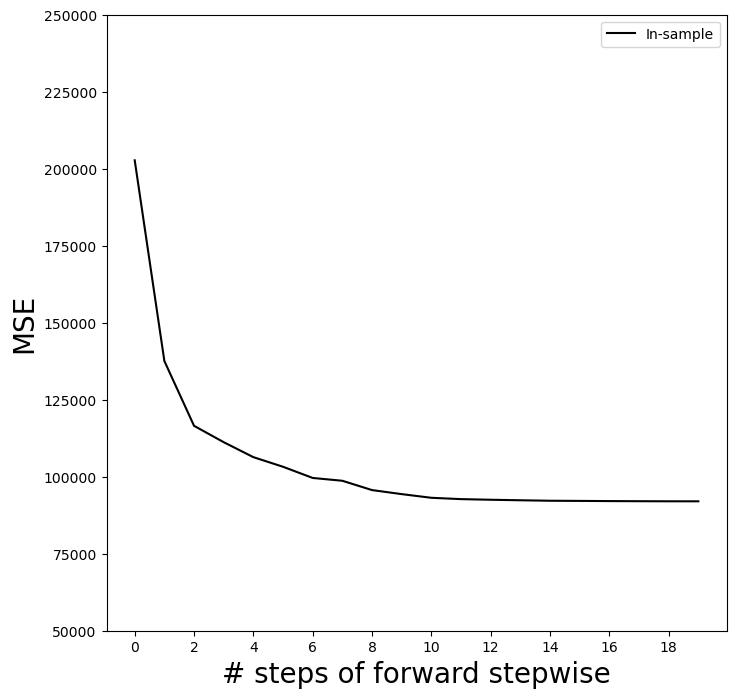

In [14]:
mse_fig, ax = subplots(figsize=(8,8))
insample_mse = ((Yhat_in - Y[:,None])**2).mean(0)
n_steps = insample_mse.shape[0]
ax.plot(np.arange(n_steps), insample_mse,'k', label='In-sample')
ax.set_ylabel('MSE', fontsize=20)
ax.set_xlabel('# steps of forward stepwise', fontsize=20)
ax.set_xticks(np.arange(n_steps)[::2])
ax.legend()
ax.set_ylim([50000,250000]);

In [15]:
K=5
kfold = skm.KFold(K, random_state=0, shuffle=True)
Yhat_cv = skm.cross_val_predict(full_path, Hitters, Y, cv=kfold)
Yhat_cv.shape

(263, 20)

In [16]:
cv_mse = []
for train_idx, test_idx in kfold.split(Y):
    errors = (Yhat_cv[test_idx] - Y[test_idx, None])**2
    cv_mse.append(errors.mean(0)) # column means
cv_mse = np.array(cv_mse).T
cv_mse.shape

(20, 5)

In [17]:
cv_mse

array([[297431.06375465, 213373.26684906, 164217.86614576,
        173485.72836052, 172188.60953974],
       [179409.9479167 , 171503.22142442, 119051.86818073,
        116989.19290773, 140209.85934929],
       [169081.87136598, 149740.51439506, 106610.80755336,
        102201.60230676, 140916.43073648],
       [161065.23003134, 158039.08094899, 109849.16390754,
        109662.66982833, 148364.79459334],
       [143343.94710477, 136954.50569394,  97833.92005879,
        101684.74147948, 145424.24181961],
       [136980.48787987, 126681.57443205, 109241.85546727,
         97215.02867442, 147981.91027703],
       [133308.92200721, 132669.47624458, 102674.2023572 ,
         90697.78162432, 140394.69989328],
       [131281.92026823, 172481.81312871,  95998.89718102,
         95674.58264061, 137972.87342947],
       [123424.15486916, 177296.93538742,  99621.93621648,
        105832.32036154, 134588.01460062],
       [122703.80987915, 170634.1192835 , 104603.25122781,
         98589.48917202

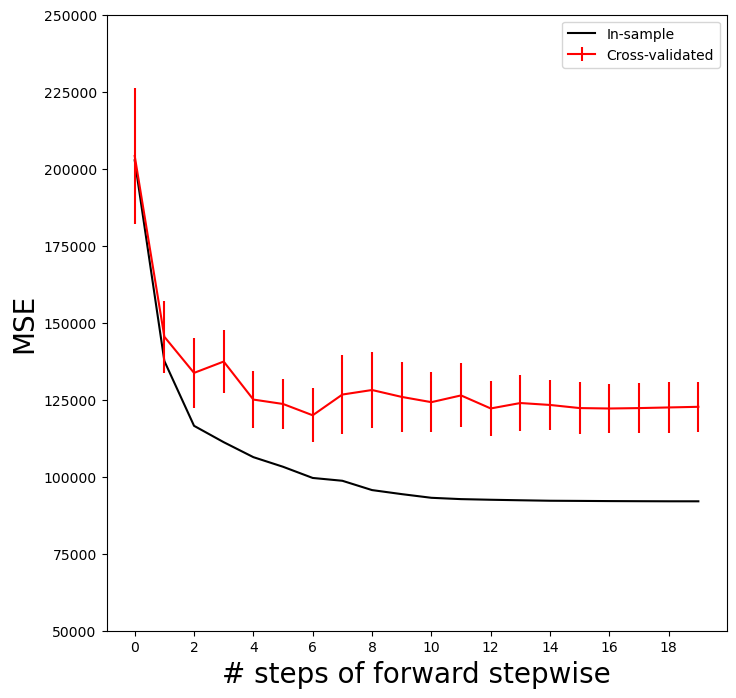

In [18]:
ax.errorbar(np.arange(n_steps), cv_mse.mean(1), cv_mse.std(1) / np.sqrt(K), label='Cross-validated', c='r') # color red
ax.set_ylim([50000,250000])
ax.legend()
mse_fig

In [19]:
validation = skm.ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_idx, test_idx in validation.split(Y):
    full_path.fit(Hitters.iloc[train_idx], Y[train_idx])
    Yhat_val = full_path.predict(Hitters.iloc[test_idx])
    errors = (Yhat_val - Y[test_idx,None])**2
    validation_mse = errors.mean(0)

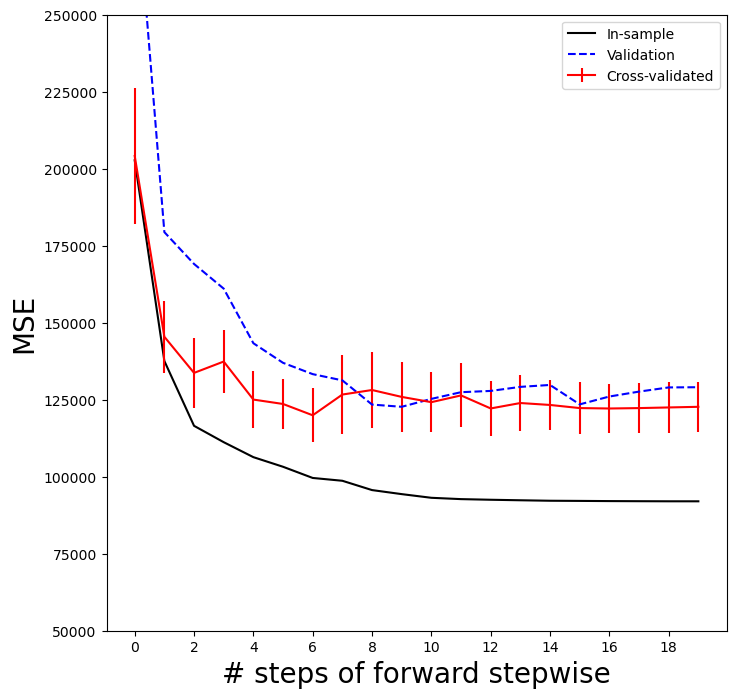

In [20]:
ax.plot(np.arange(n_steps), validation_mse, 'b--', label='Validation')
ax.set_xticks(np.arange(n_steps)[::2])
ax.set_ylim([50000,250000])
ax.legend()
mse_fig

In [21]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import LinearRegression

In [22]:
df = load_data('Hitters')
np.isnan(Hitters['Salary']).sum()
df = Hitters.dropna();
df.shape
df = pd.get_dummies(df, drop_first=True)

In [23]:
X1 = df.drop(columns = 'Salary')
Y1 = df['Salary']

In [24]:
X1.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,True,True,True
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,False,True,False
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3,True,False,True
4,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4,True,False,True
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25,False,True,False


In [25]:
reg = LinearRegression().fit(X1, Y1)
reg.fit(X1, Y1)

LinearRegression()

In [26]:
reg.coef_

array([  -1.9798729 ,    7.50076754,    4.3308829 ,   -2.37620998,
         -1.04496196,    6.23128632,   -3.48905426,   -0.17134047,
          0.13399096,   -0.17286107,    1.45430494,    0.8077088 ,
         -0.81157091,    0.28189251,    0.37106921,   -3.36076048,
         62.59942304, -116.84924564,  -24.76232511])

In [27]:
sfs1 = SFS(reg, 
           k_features = 'best',
          forward = True,
          floating = False,
          verbose = 2,
          scoring = 'neg_mean_squared_error',
          cv=5)

sfs1 = sfs1.fit(X,Y)


[2025-05-22 10:07:10] Features: 1/20 -- score: -142142.865462403
[2025-05-22 10:07:10] Features: 2/20 -- score: -124277.83941532117
[2025-05-22 10:07:10] Features: 3/20 -- score: -120082.15674627219
[2025-05-22 10:07:11] Features: 4/20 -- score: -117217.98393288857
[2025-05-22 10:07:11] Features: 5/20 -- score: -114112.2212526256
[2025-05-22 10:07:11] Features: 6/20 -- score: -110162.26143793552
[2025-05-22 10:07:11] Features: 7/20 -- score: -110162.26143793555
[2025-05-22 10:07:11] Features: 8/20 -- score: -110553.2314637054
[2025-05-22 10:07:11] Features: 9/20 -- score: -110934.55461860604
[2025-05-22 10:07:11] Features: 10/20 -- score: -111236.70073017215
[2025-05-22 10:07:11] Features: 11/20 -- score: -110021.54194950026
[2025-05-22 10:07:11] Features: 12/20 -- score: -110792.91273537764
[2025-05-22 10:07:11] Features: 13/20 -- score: -111570.44903607722
[2025-05-22 10:07:11] Features: 14/20 -- score: -112677.57758021152
[2025-05-22 10:07:11] Features: 15/20 -- score: -113601.7444

In [28]:
sfs1.k_feature_idx_

(0, 1, 2, 4, 6, 7, 11, 12, 13, 15, 16)

In [66]:
X1.columns[list(sfs1.k_feature_idx_)]

Index(['AtBat', 'Hits', 'HmRun', 'RBI', 'Years', 'CAtBat', 'CRBI', 'CWalks',
       'PutOuts', 'Errors', 'League_N'],
      dtype='object')

In [30]:
metric_data = sfs1.get_metric_dict(confidence_interval=0.95)

metric_data

{1: {'feature_idx': (12,),
  'cv_scores': array([ -69552.92336717, -213009.92207213, -118946.76030707,
         -207644.13810831, -101560.58345733]),
  'avg_score': -142142.865462403,
  'feature_names': ('CRBI',),
  'ci_bound': 74428.9698843153,
  'std_dev': 57908.26716673031,
  'std_err': 28954.133583365154},
 2: {'feature_idx': (2, 12),
  'cv_scores': array([ -53798.49669675, -163254.8070404 , -104610.93335577,
         -201906.21884294,  -97818.74114074]),
  'avg_score': -124277.83941532117,
  'feature_names': ('Hits', 'CRBI'),
  'ci_bound': 67031.53347327336,
  'std_dev': 52152.810323711616,
  'std_err': 26076.405161855804},
 3: {'feature_idx': (2, 12, 15),
  'cv_scores': array([ -62163.90514053, -153941.83393405,  -97468.14894897,
         -191620.10821684,  -95216.78749097]),
  'avg_score': -120082.15674627219,
  'feature_names': ('Hits', 'CRBI', 'Division[W]'),
  'ci_bound': 59591.94214940614,
  'std_dev': 46364.55552637389,
  'std_err': 23182.277763186947},
 4: {'feature_idx': 

In [31]:
df_metric = pd.DataFrame.from_dict(metric_data).T
df_metric

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(12,)","[-69552.92336716877, -213009.92207213468, -118...",-142142.865462,"(CRBI,)",74428.969884,57908.267167,28954.133583
2,"(2, 12)","[-53798.49669675372, -163254.80704040316, -104...",-124277.839415,"(Hits, CRBI)",67031.533473,52152.810324,26076.405162
3,"(2, 12, 15)","[-62163.905140528004, -153941.8339340546, -974...",-120082.156746,"(Hits, CRBI, Division[W])",59591.942149,46364.555526,23182.277763
4,"(2, 12, 15, 16)","[-65576.39003922707, -141278.46897398742, -825...",-117217.983933,"(Hits, CRBI, Division[W], PutOuts)",56263.230127,43774.704486,21887.352243
5,"(1, 2, 12, 15, 16)","[-64199.085454696164, -133171.50527159404, -83...",-114112.221253,"(AtBat, Hits, CRBI, Division[W], PutOuts)",54818.569767,42650.709646,21325.354823
6,"(1, 2, 6, 12, 15, 16)","[-60075.5341221432, -132306.39833204861, -7659...",-110162.261438,"(AtBat, Hits, Walks, CRBI, Division[W], PutOuts)",57689.191989,44884.151259,22442.075629
7,"(0, 1, 2, 6, 12, 15, 16)","[-60075.534122143144, -132306.39833204844, -76...",-110162.261438,"(intercept, AtBat, Hits, Walks, CRBI, Division...",57689.191989,44884.151259,22442.075629
8,"(0, 1, 2, 4, 6, 12, 15, 16)","[-60330.259290065784, -132346.01741313474, -76...",-110553.231464,"(intercept, AtBat, Hits, Runs, Walks, CRBI, Di...",58252.099546,45322.112462,22661.056231
9,"(0, 1, 2, 4, 6, 7, 12, 15, 16)","[-64303.54034551636, -130892.95408839597, -745...",-110934.554619,"(intercept, AtBat, Hits, Runs, Walks, Years, C...",57911.784603,45057.335875,22528.667937
10,"(0, 1, 2, 4, 6, 7, 11, 12, 15, 16)","[-63508.04380015556, -137971.21159579075, -752...",-111236.70073,"(intercept, AtBat, Hits, Runs, Walks, Years, C...",57344.878076,44616.263337,22308.131669


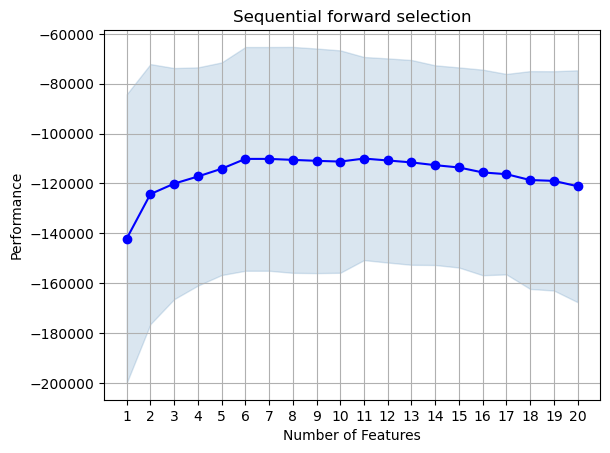

In [32]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig1 = plot_sfs(metric_data, kind = 'std_dev')

plt.title("Sequential forward selection")
plt.grid()
plt.show()